# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

# Define features

In [3]:
features = ['RhythmScore', 'AudioLoudness', 'VocalContent', 'AcousticQuality', 
            'InstrumentalScore', 'LivePerformanceLikelihood', 'MoodScore', 
            'TrackDurationMs', 'Energy']
X = train[features]
y = train['BeatsPerMinute']
X_test = test[features]

# Feature engineering: Log-transform skewed features


In [4]:
X['AudioLoudness'] = np.log1p(-X['AudioLoudness'])
X_test['AudioLoudness'] = np.log1p(-X_test['AudioLoudness'])
X['TrackDurationMs'] = np.log1p(X['TrackDurationMs'])
X_test['TrackDurationMs'] = np.log1p(X_test['TrackDurationMs'])

C:\Users\nishi\AppData\Local\Temp\ipykernel_18496\3028610528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['AudioLoudness'] = np.log1p(-X['AudioLoudness'])
C:\Users\nishi\AppData\Local\Temp\ipykernel_18496\3028610528.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['AudioLoudness'] = np.log1p(-X_test['AudioLoudness'])
C:\Users\nishi\AppData\Local\Temp\ipykernel_18496\3028610528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

# Split data first


In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features separately for train and val


In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


# Train Random Forest with adjusted params (based on 26.38882, slight tweak)


In [7]:
rf = RandomForestRegressor(n_estimators=140, max_depth=10, min_samples_split=5, 
                          random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

,n_estimators,140
,criterion,'squared_error'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Validate


In [8]:
rf_pred = rf.predict(X_val_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
print(f"Validation RMSE: {rf_rmse:.4f}")

Validation RMSE: 26.4398


# 5-fold Cross-Validation


In [9]:
cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
cv_rmse = -cv_scores.mean()
print(f"5-Fold CV RMSE: {cv_rmse:.4f}")

5-Fold CV RMSE: 26.4682


# Feature Importance (optional, for insight)


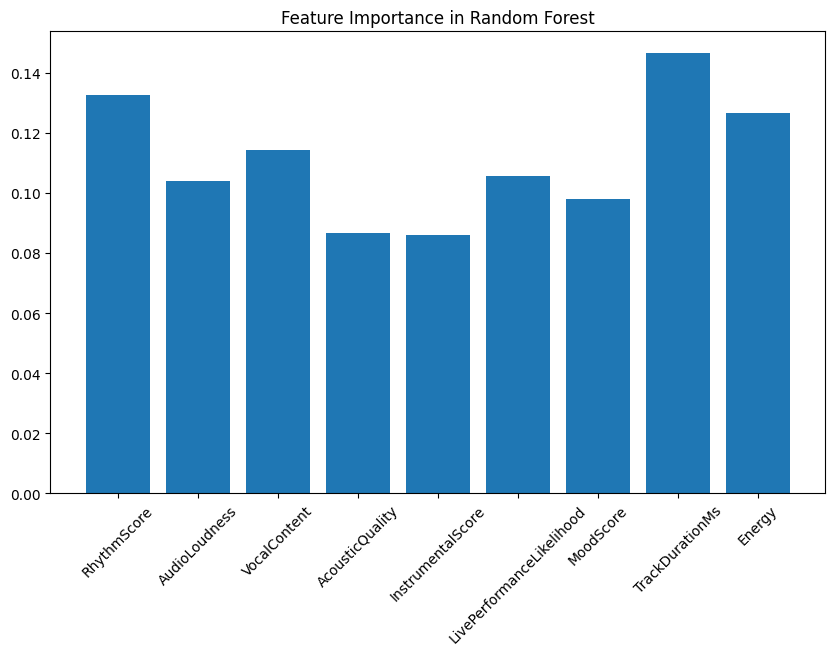

In [10]:
importances = rf.feature_importances_
feature_names = features
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.title('Feature Importance in Random Forest')
plt.xticks(rotation=45)
plt.show()

# Generate test predictions

In [11]:
test_pred = rf.predict(X_test_scaled)
submission['BeatsPerMinute'] = test_pred
submission.to_csv('submission_rf_stabilized.csv', index=False)
print("Submission file created: submission_rf_stabilized.csv")

Submission file created: submission_rf_stabilized.csv
